In [75]:
# general stuff
import locale
locale.setlocale(locale.LC_ALL, 'en_US')

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

import os

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

!pwd

/Users/mattbaldree/Google Drive/smu/quantifying/QTW_14/QTW_14


In [29]:
# flags

PURGE_DATA = True

plan of attack

- ~~download files in parallel~~
- ~~view a file~~
- ~~read files in parallel to csv format~~
- ~~convert to hdf5 format~~
- column manipulation

In [30]:
# start Dask distributed client and print out stats

from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:55985 Dashboard: http://127.0.0.1:55986,Cluster Workers: 4 Cores: 4 Memory: 10.31 GB


In [31]:
# if loading data, then purge existing data directory.

if PURGE_DATA:
    # delete /data directory
    from shutil import rmtree

    path = 'data'
    if os.path.exists(path):
        rmtree(path)
    
    # make /data if it doesn't exist
    path = 'data'
    if not os.path.exists(path):
        os.mkdir(path)

In [32]:
# if loading data, download files and decompress them in parallel.

DOWNLOAD_ONE_FILE_ONLY = True

if PURGE_DATA:
    import urllib.request
    import shutil
    import bz2
    
    def download_file(baseurl, yr):
        file_name = ''

        url_of_data_file = baseurl%(yr)
        file_name = 'data/%d.csv'%(yr)
        size = 0

        print('downloading', url_of_data_file, 'to', file_name)
        decompressor = bz2.BZ2Decompressor()

        # download file and decompress it
        with urllib.request.urlopen(url_of_data_file) as response, open(file_name, 'wb') as out_file:
                data = decompressor.decompress(response.read())
                out_file.write(data)
                size = len(data)
                print('file size (MB)', locale.format('%.1f', size/1000000, grouping=True))

        return(file_name, size)
    
    def print_files(files):
        totalSize = 0        
        for f in files:
            size = f[1]/1000000
            totalSize += size
            print('downloaded file:', f[0], ', of size (MB):', 
                  locale.format('%.1f', size, grouping=True))
            
        print('Number of files downloaded:', len(files), 'for a total size (MB):', 
              locale.format('%.1f', totalSize, grouping=True))


    if DOWNLOAD_ONE_FILE_ONLY:
        # testing
        download_file('http://stat-computing.org/dataexpo/2009/%d.csv.bz2', 1987)
    else:    
        # download airline data from 1987 to 2009
        yrs = range(1987, 2009)
        baseurl = 'http://stat-computing.org/dataexpo/2009/%d.csv.bz2'

        from dask import delayed
        download_file = delayed(download_file)

        files = [download_file(baseurl, yr) for yr in yrs]
        files = delayed(files)

        %time files = files.compute()   
      
        print_files(files)

downloading http://stat-computing.org/dataexpo/2009/1987.csv.bz2 to data/1987.csv
file size (MB) 127.2


**Click on Dashboard URL printed out above to see the distributed work.**

In [33]:
# print the head of a csv file

print('csv file format')
!head data/1987.csv

csv file format
Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1987,10,14,3,741,730,912,849,PS,1451,NA,91,79,NA,23,11,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,15,4,729,730,903,849,PS,1451,NA,94,79,NA,14,-1,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,17,6,741,730,918,849,PS,1451,NA,97,79,NA,29,11,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,18,7,729,730,847,849,PS,1451,NA,78,79,NA,-2,-1,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,19,1,749,730,922,849,PS,1451,NA,93,79,NA,33,19,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,21,3,728,730,848,849,PS,1451,NA,80,79,NA,-1,-2,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,22,4,728,730,852,849,PS,1451,NA,84,79,NA,3,-2,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,23,5,731,730

In [53]:
# load csv files into a dataframe in parallel

filename = os.path.join('data', '*.csv')
print('Loading', filename, 'files')

import dask.dataframe as dd
%time df_csv = dd.read_csv(filename, assume_missing=True, dtype={'TailNum':np.object, 'CancellationCode':np.object}).rename(columns=str.lower)

print(df_csv.dtypes)
df_csv.head()

Loading data/*.csv files
CPU times: user 28.8 ms, sys: 8.01 ms, total: 36.9 ms
Wall time: 34.2 ms
year                 float64
month                float64
dayofmonth           float64
dayofweek            float64
deptime              float64
crsdeptime           float64
arrtime              float64
crsarrtime           float64
uniquecarrier         object
flightnum            float64
tailnum               object
actualelapsedtime    float64
crselapsedtime       float64
airtime              float64
arrdelay             float64
depdelay             float64
origin                object
dest                  object
distance             float64
taxiin               float64
taxiout              float64
cancelled            float64
cancellationcode      object
diverted             float64
carrierdelay         float64
weatherdelay         float64
nasdelay             float64
securitydelay        float64
lateaircraftdelay    float64
dtype: object


,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,tailnum,actualelapsedtime,crselapsedtime,airtime,arrdelay,depdelay,origin,dest,distance,taxiin,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,1987.0,10.0,14.0,3.0,741.0,730.0,912.0,849.0,PS,1451.0,NaN,91.0,79.0,NaN,23.0,11.0,SAN,SFO,447.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,1987.0,10.0,15.0,4.0,729.0,730.0,903.0,849.0,PS,1451.0,NaN,94.0,79.0,NaN,14.0,-1.0,SAN,SFO,447.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,1987.0,10.0,17.0,6.0,741.0,730.0,918.0,849.0,PS,1451.0,NaN,97.0,79.0,NaN,29.0,11.0,SAN,SFO,447.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,1987.0,10.0,18.0,7.0,729.0,730.0,847.0,849.0,PS,1451.0,NaN,78.0,79.0,NaN,-2.0,-1.0,SAN,SFO,447.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,1987.0,10.0,19.0,1.0,749.0,730.0,922.0,849.0,PS,1451.0,NaN,93.0,79.0,NaN,33.0,19.0,SAN,SFO,447.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [56]:
# categorize appropriate columns

object_columns = ['uniquecarrier', 'tailnum', 'origin', 'dest', 'cancellationcode']
for i in object_columns:
    df_csv[i] = df_csv[i].astype('category')

df_csv = df_csv.categorize()

In [68]:
df_csv.dtypes

year                  float64
month                 float64
dayofmonth            float64
dayofweek             float64
deptime               float64
crsdeptime            float64
arrtime               float64
crsarrtime            float64
uniquecarrier        category
flightnum             float64
tailnum              category
actualelapsedtime     float64
crselapsedtime        float64
airtime               float64
arrdelay              float64
depdelay              float64
origin               category
dest                 category
distance              float64
taxiin                float64
taxiout               float64
cancelled             float64
cancellationcode     category
diverted              float64
carrierdelay          float64
weatherdelay          float64
nasdelay              float64
securitydelay         float64
lateaircraftdelay     float64
dtype: object

In [74]:
# shape of dataframe

number_of_items = df_csv.size.compute()
locale.format('%d', number_of_items, grouping=True)

'38,042,954'

Top origin airports


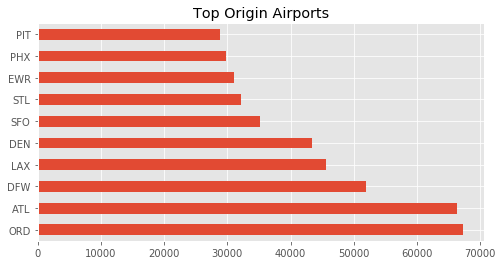

In [134]:
# Top 10 origin airports
origin_counts = df_csv.origin.value_counts().compute().head(10)
print('Top origin airports')
origin_counts

origin_counts.plot(kind='barh', figsize=(8,4), title='Top Origin Airports')